## Topic: Revolutionizing Fashion Creation: A GAN-based Approach for Automated Watch Design Generation

##### Please note that the images were generated originally trained on 3500 epochs but then rerun on 1 epoch to ensure that the notebook is able to save as it was too heavy to do so. This does not affect the results gotten from the research.
##### The generator and discriminator loss chart was already saved before retraining.

## Import all the libraries necessary 

In [1]:
# Import all necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
%matplotlib inline
import os
from keras.preprocessing import image
import time
import cv2
from PIL import Image
from random import sample
import matplotlib.image as mpimg
from skimage import exposure
import scipy.stats
from scipy.stats import zscore, norm
from tensorflow.keras.preprocessing import image
import tensorflow as tf
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
from keras import layers
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import BatchNormalization, Activation, Input
from tensorflow.keras.layers import Conv2D, ZeroPadding2D
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy
from skimage.metrics import mean_squared_error
from IPython import display

In [2]:
data_path = 'fashion-dataset'

In [3]:
print(os.listdir(data_path))

['.ipynb_checkpoints', 'GAN_Research.ipynb', 'images', 'images.csv', 'styles', 'styles.csv']


In [4]:
image_path = 'fashion-dataset/images.csv'

In [5]:
styles_path = 'fashion-dataset/styles.csv'

In [6]:
df_images = pd.read_csv(image_path, on_bad_lines='skip')

In [7]:
df_images.head()

filename                                               link
0  15970.jpg  http://assets.myntassets.com/v1/images/style/p...
1  39386.jpg  http://assets.myntassets.com/v1/images/style/p...
2  59263.jpg  http://assets.myntassets.com/v1/images/style/p...
3  21379.jpg  http://assets.myntassets.com/v1/images/style/p...
4  53759.jpg  http://assets.myntassets.com/v1/images/style/p...

In [8]:
df_styles = pd.read_csv(styles_path, on_bad_lines='skip')

In [9]:
df_styles.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt

In [10]:
df_images['identity'] = df_images['filename'].apply(lambda x: x[:-4])
df_images

filename                                               link identity
0      15970.jpg  http://assets.myntassets.com/v1/images/style/p...    15970
1      39386.jpg  http://assets.myntassets.com/v1/images/style/p...    39386
2      59263.jpg  http://assets.myntassets.com/v1/images/style/p...    59263
3      21379.jpg  http://assets.myntassets.com/v1/images/style/p...    21379
4      53759.jpg  http://assets.myntassets.com/v1/images/style/p...    53759
...          ...                                                ...      ...
44441  17036.jpg  http://assets.myntassets.com/v1/images/style/p...    17036
44442   6461.jpg  http://assets.myntassets.com/v1/images/style/p...     6461
44443  18842.jpg  http://assets.myntassets.com/v1/images/style/p...    18842
44444  46694.jpg  http://assets.myntassets.com/v1/images/style/p...    46694
44445  51623.jpg  http://assets.myntassets.com/assets/images/516...    51623

[44446 rows x 3 columns]

In [11]:
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  44446 non-null  object
 1   link      44446 non-null  object
 2   identity  44446 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [12]:
df_images['identity'] = df_images['identity'].astype(int)

In [13]:
comb_df = pd.merge(df_styles, df_images, right_on='identity', left_on='id')

In [14]:
comb_df

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44419  17036    Men       Footwear       Shoes           Casual Shoes   
44420   6461    Men       Footwear  Flip Flops             Flip Flops   
44421  18842    Men        Apparel     Topwear                Tshirts   
44422  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44423  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
44419      White  Summer  2013.0  Casual   
44420        Red  Summer  2011.0  Casual   
44421       Blue    Fall  2011.0  Casual   
44422       Blue  Spring  2017.0  Casual   
44423       Pink  Winter  2016.0  Casual   

                                    productDisplayName   filename  \
0                     Turtle Check Men Navy Blue Shirt  15970.jpg   
1                   Peter England Men Party Blue Jeans  39386.jpg   
2                             Titan Women Silver Watch  59263.jpg   
3        Manchester United Men Solid Black Track Pants  21379.jpg   
4                                Puma Men Grey T-shirt  53759.jpg   
...                                                ...        ...   
44419                        Gas Men Caddy Casual Shoe  17036.jpg   
44420               Lotto Men's Soccer Track Flip Flop   6461.jpg   
44421             Puma Men Graphic Stellar Blue Tshirt  18842.jpg   
44422                   Rasasi Women Blue Lady Perfume  46694.jpg   
44423  Fossil Women Pink Dial Chronograph Watch ES3050  51623.jpg   

                                                    link  identity  
0      http://assets.myntassets.com/v1/images/style/p...     15970  
1      http://assets.myntassets.com/v1/images/style/p...     39386  
2      http://assets.myntassets.com/v1/images/style/p...     59263  
3      http://assets.myntassets.com/v1/images/style/p...     21379  
4      http://assets.myntassets.com/v1/images/style/p...     53759  
...                                                  ...       ...  
44419  http://assets.myntassets.com/v1/images/style/p...     17036  
44420  http://assets.myntassets.com/v1/images/style/p...      6461  
44421  http://assets.myntassets.com/v1/images/style/p...     18842  
44422  http://assets.myntassets.com/v1/images/style/p...     46694  
44423  http://assets.myntassets.com/assets/images/516...     51623  

[44424 rows x 13 columns]

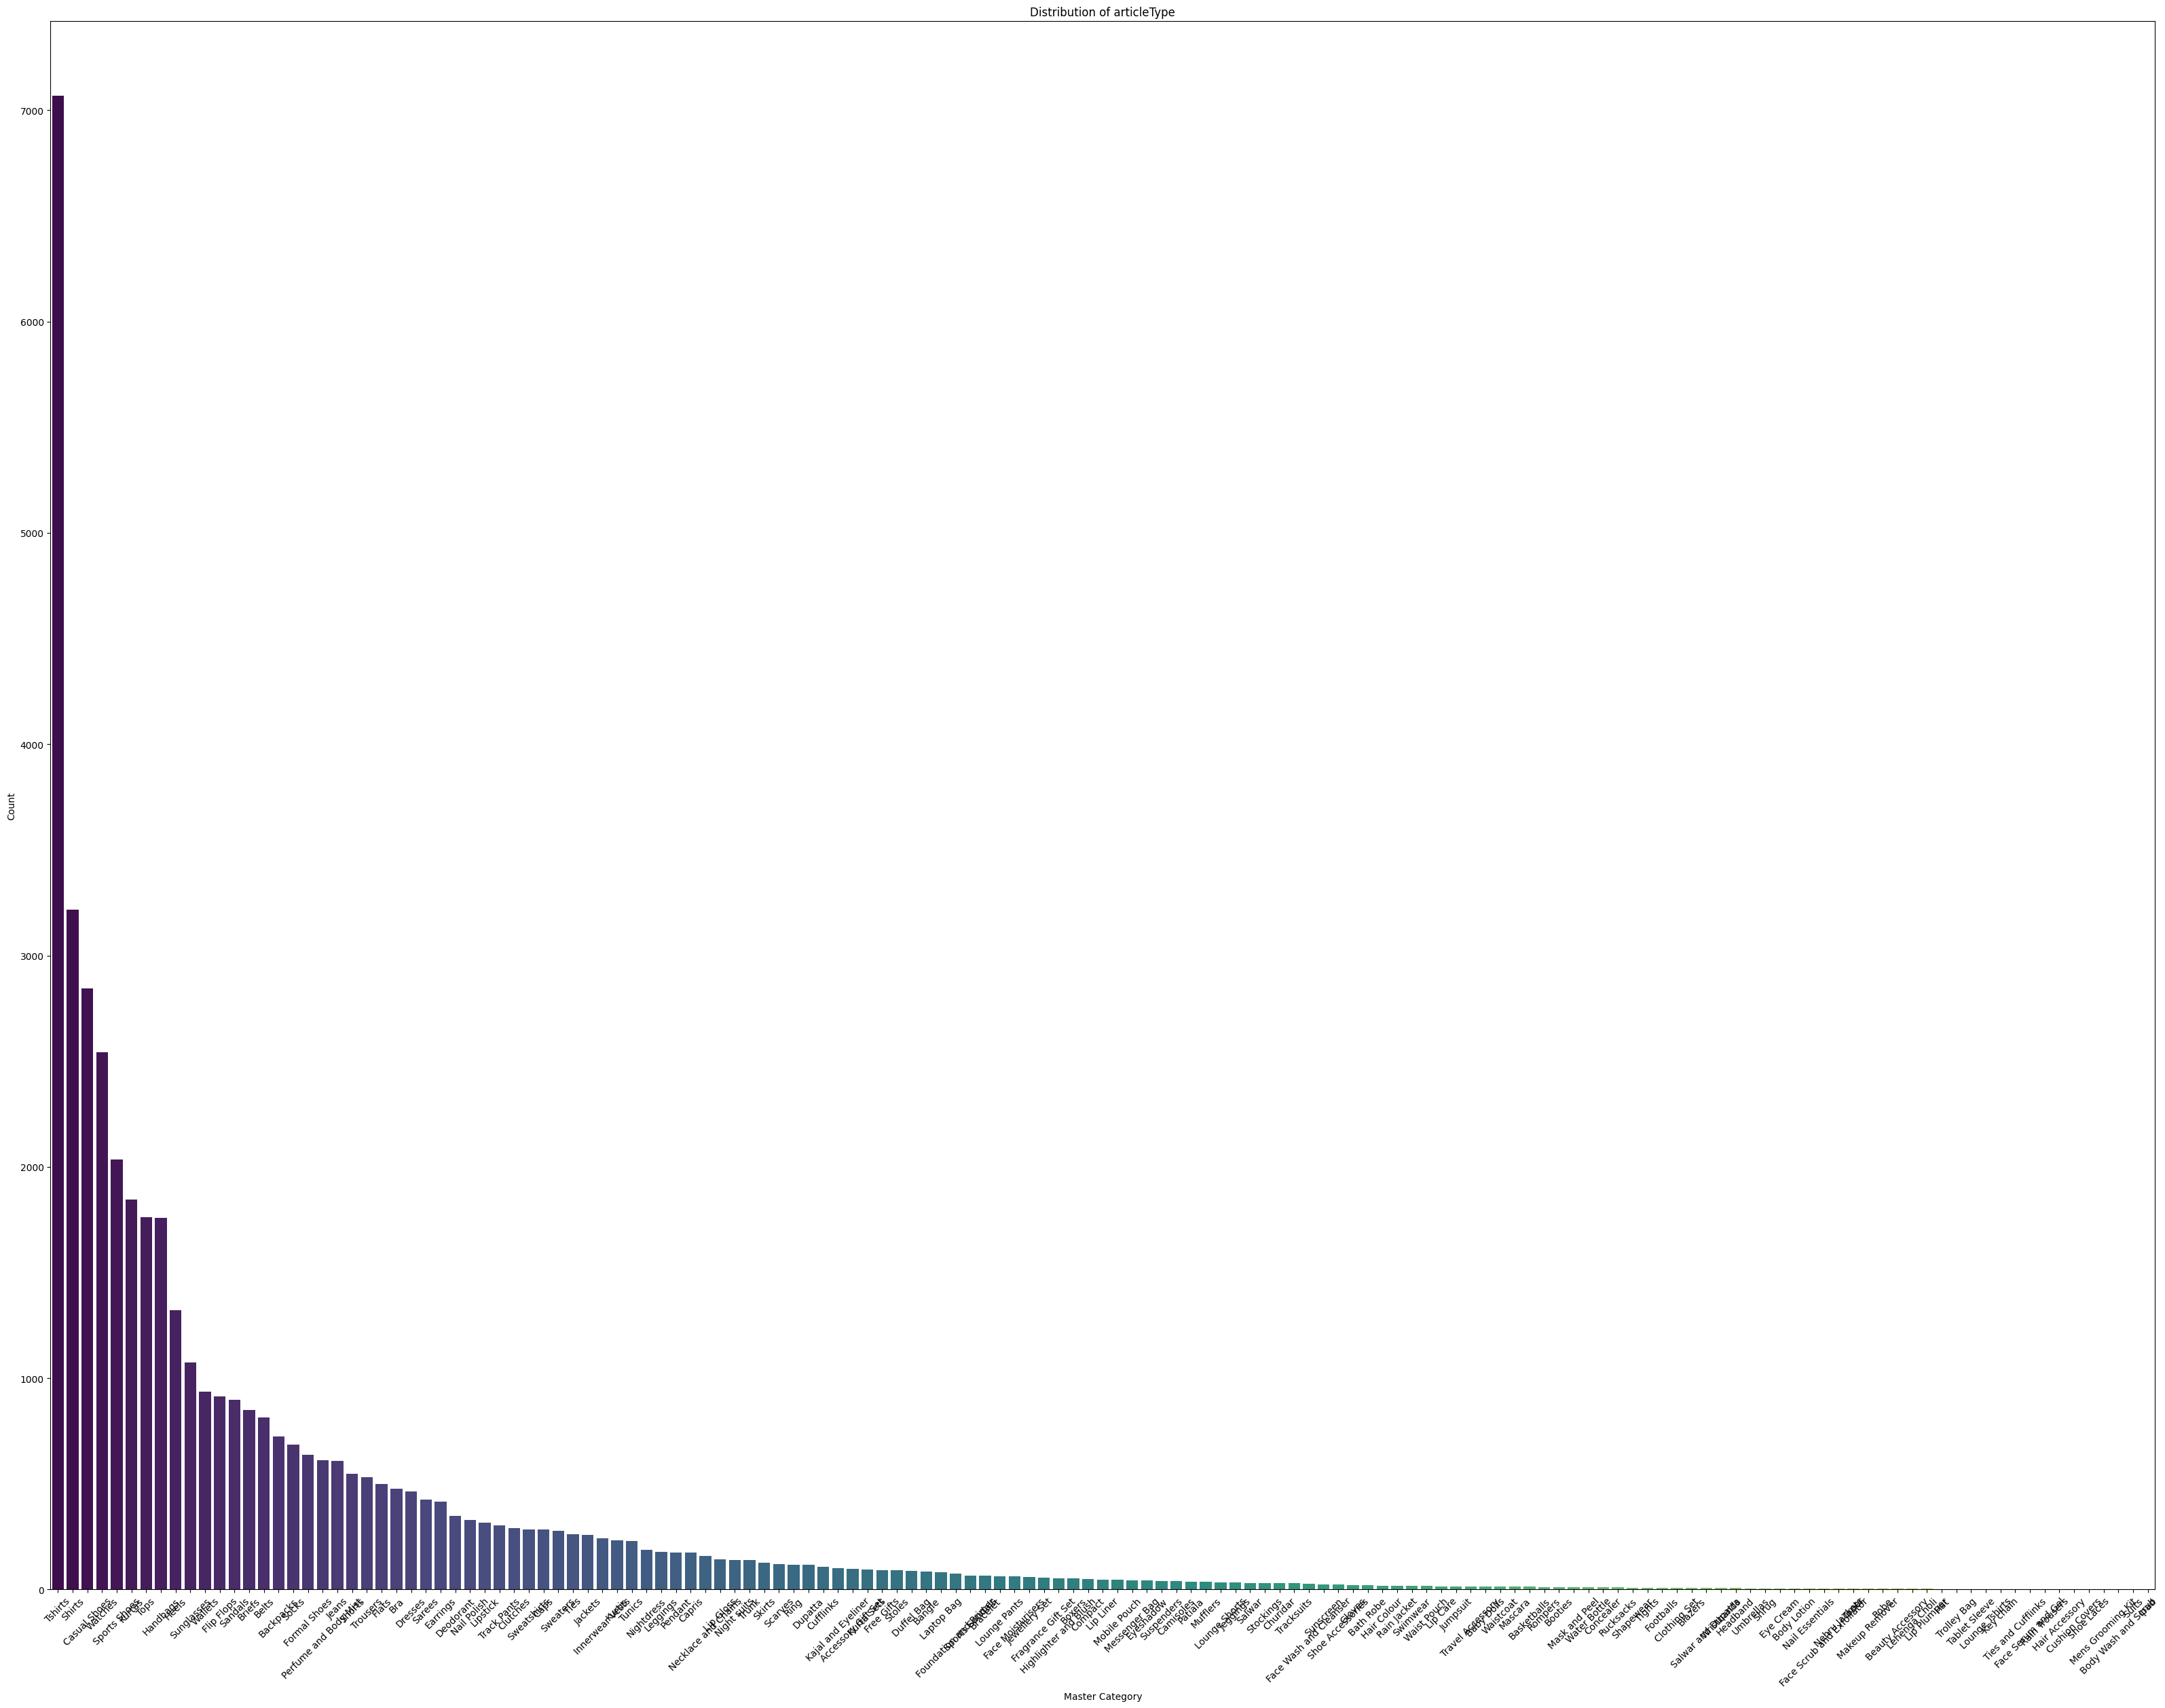

In [15]:
# Count the occurrences of each category in the 'masterCategory' column
category_counts = comb_df['articleType'].value_counts()

# Create a bar plot
plt.figure(figsize=(40, 30))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title('Distribution of articleType')
plt.xlabel('Master Category')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

==============Images==============


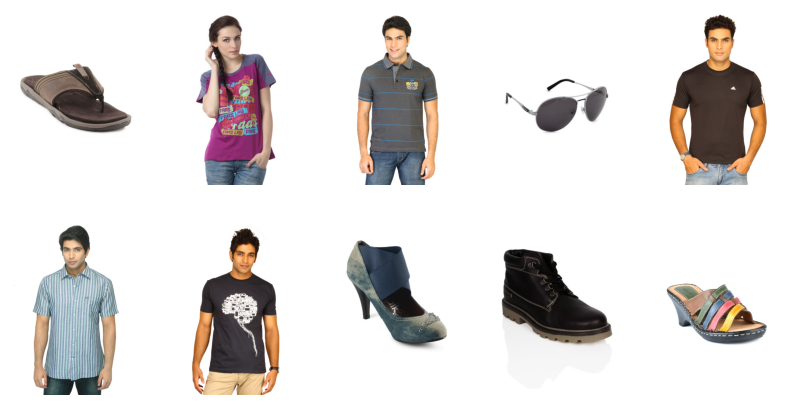

In [16]:
def load_images():
    # Store the directory path in a variable
    images_path = "C:/Users/atuam/Desktop/Final_project/fashion-dataset/images"

    # List the images in this directory
    images = os.listdir(images_path)

    # Create an empty list to store images
    images_list = []

    # Load 10 Random Images: Sample out 10 images randomly from the above list
    sample_images = sample(images, 10)

    fig = plt.figure(figsize=(10, 5))

    print("==============Images==============")
    for i, img_name in enumerate(sample_images):
        plt.subplot(2, 5, i+1)
        img_path = os.path.join(images_path, img_name)
        loaded_img = Image.open(img_path)
        
        # Convert the PIL Image to a NumPy array
        img_array = tf.keras.preprocessing.image.img_to_array(loaded_img).astype('uint8')
        
        images_list.append(img_array)

        plt.imshow(loaded_img)
        plt.axis('off')

    plt.show()

    # Return the list of images
    return images_list

# Call the function to load and visualize images
loaded_images = load_images()

### Filtering for watches

In [17]:
watches_df = comb_df[comb_df['articleType'].str.contains('Watches')]

In [18]:
watches_df

id gender masterCategory subCategory articleType baseColour  season  \
2      59263  Women    Accessories     Watches     Watches     Silver  Winter   
9      30039    Men    Accessories     Watches     Watches      Black  Winter   
16     29928    Men    Accessories     Watches     Watches      Black  Winter   
20     17429    Men    Accessories     Watches     Watches      Black  Winter   
38     51658  Women    Accessories     Watches     Watches     Copper  Winter   
...      ...    ...            ...         ...         ...        ...     ...   
44390  45223    Men    Accessories     Watches     Watches      White  Winter   
44398  32371  Women    Accessories     Watches     Watches      White  Winter   
44403  45011    Men    Accessories     Watches     Watches      Steel  Winter   
44413  40563  Women    Accessories     Watches     Watches      White  Winter   
44423  51623  Women    Accessories     Watches     Watches       Pink  Winter   

         year   usage                                 productDisplayName  \
2      2016.0  Casual                           Titan Women Silver Watch   
9      2016.0  Casual                             Skagen Men Black Watch   
16     2016.0  Casual            Police Men Black Dial Watch PL12889JVSB   
20     2016.0  Casual  CASIO G-Shock Men Black Digital Watch G-7710-1...   
38     2016.0  Casual       Fossil Women Copper Chronograph Watch CH2589   
...       ...     ...                                                ...   
44390  2016.0  Casual  Casio Vintage Collection Analog-Digital Watch ...   
44398  2016.0  Casual                         Q&Q Women White Dial Watch   
44403  2016.0  Casual             Maxima Men Digital Multifunction Watch   
44413  2016.0  Casual            Titan Women White Dial Watch NB9701WM01   
44423  2016.0  Casual    Fossil Women Pink Dial Chronograph Watch ES3050   

        filename                                               link  identity  
2      59263.jpg  http://assets.myntassets.com/v1/images/style/p...     59263  
9      30039.jpg  http://assets.myntassets.com/v1/images/style/p...     30039  
16     29928.jpg  http://assets.myntassets.com/v1/images/style/p...     29928  
20     17429.jpg  http://assets.myntassets.com/assets/images/174...     17429  
38     51658.jpg  http://assets.myntassets.com/v1/images/style/p...     51658  
...          ...                                                ...       ...  
44390  45223.jpg  http://assets.myntassets.com/assets/images/452...     45223  
44398  32371.jpg  http://assets.myntassets.com/v1/images/style/p...     32371  
44403  45011.jpg  http://assets.myntassets.com/v1/images/style/p...     45011  
44413  40563.jpg  http://assets.myntassets.com/v1/images/style/p...     40563  
44423  51623.jpg  http://assets.myntassets.com/assets/images/516...     51623  

[2542 rows x 13 columns]

In [19]:
watches_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2542 entries, 2 to 44423
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2542 non-null   int64  
 1   gender              2542 non-null   object 
 2   masterCategory      2542 non-null   object 
 3   subCategory         2542 non-null   object 
 4   articleType         2542 non-null   object 
 5   baseColour          2542 non-null   object 
 6   season              2542 non-null   object 
 7   year                2542 non-null   float64
 8   usage               2542 non-null   object 
 9   productDisplayName  2542 non-null   object 
 10  filename            2542 non-null   object 
 11  link                2542 non-null   object 
 12  identity            2542 non-null   int32  
dtypes: float64(1), int32(1), int64(1), object(10)
memory usage: 268.1+ KB


## Create new folders and resize the images

In [20]:
from PIL import Image

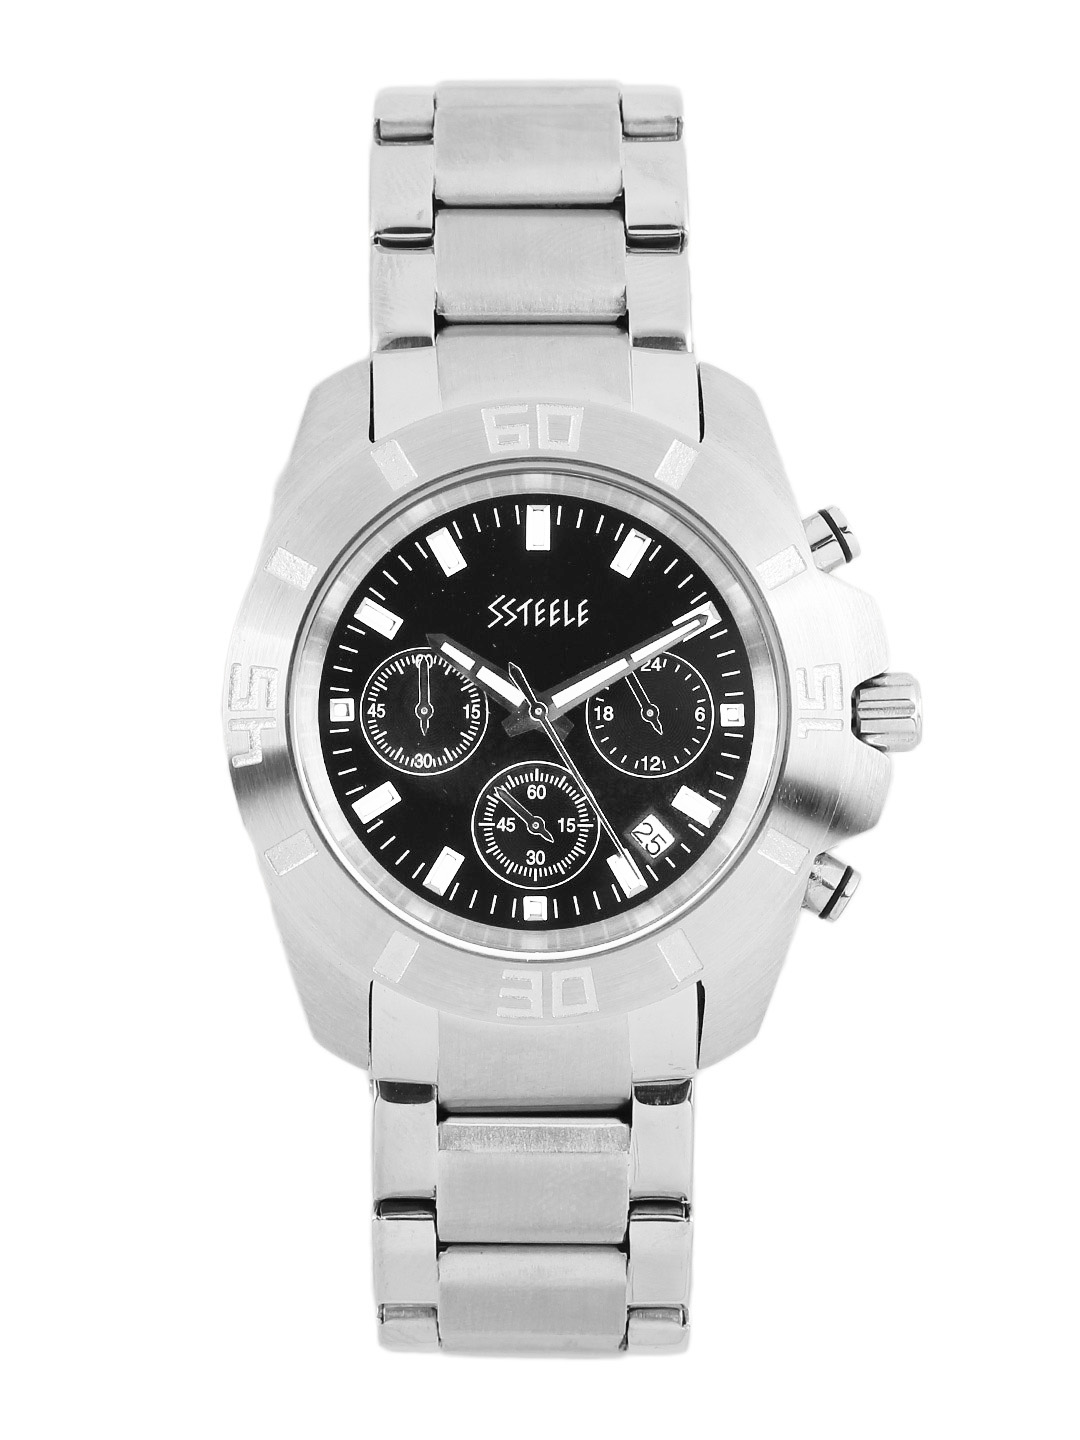

In [21]:
Image.open(f'fashion-dataset/Images/45909.jpg')

In [22]:
# Create a folder to store the images
output_folder = 'fashion-dataset/images/watches_images'
os.makedirs(output_folder, exist_ok=True)

In [23]:
for i, row in watches_df.iterrows():
    #
    filename = row['filename']
    image_path = 'fashion-dataset/images/'
    
    if os.path.isfile(image_path + filename):
        watches = Image.open(image_path + filename)
        path_watches = os.path.join(output_folder, filename)
        watches.save(path_watches)
        
    else:
        print(f"Image:{filename}")

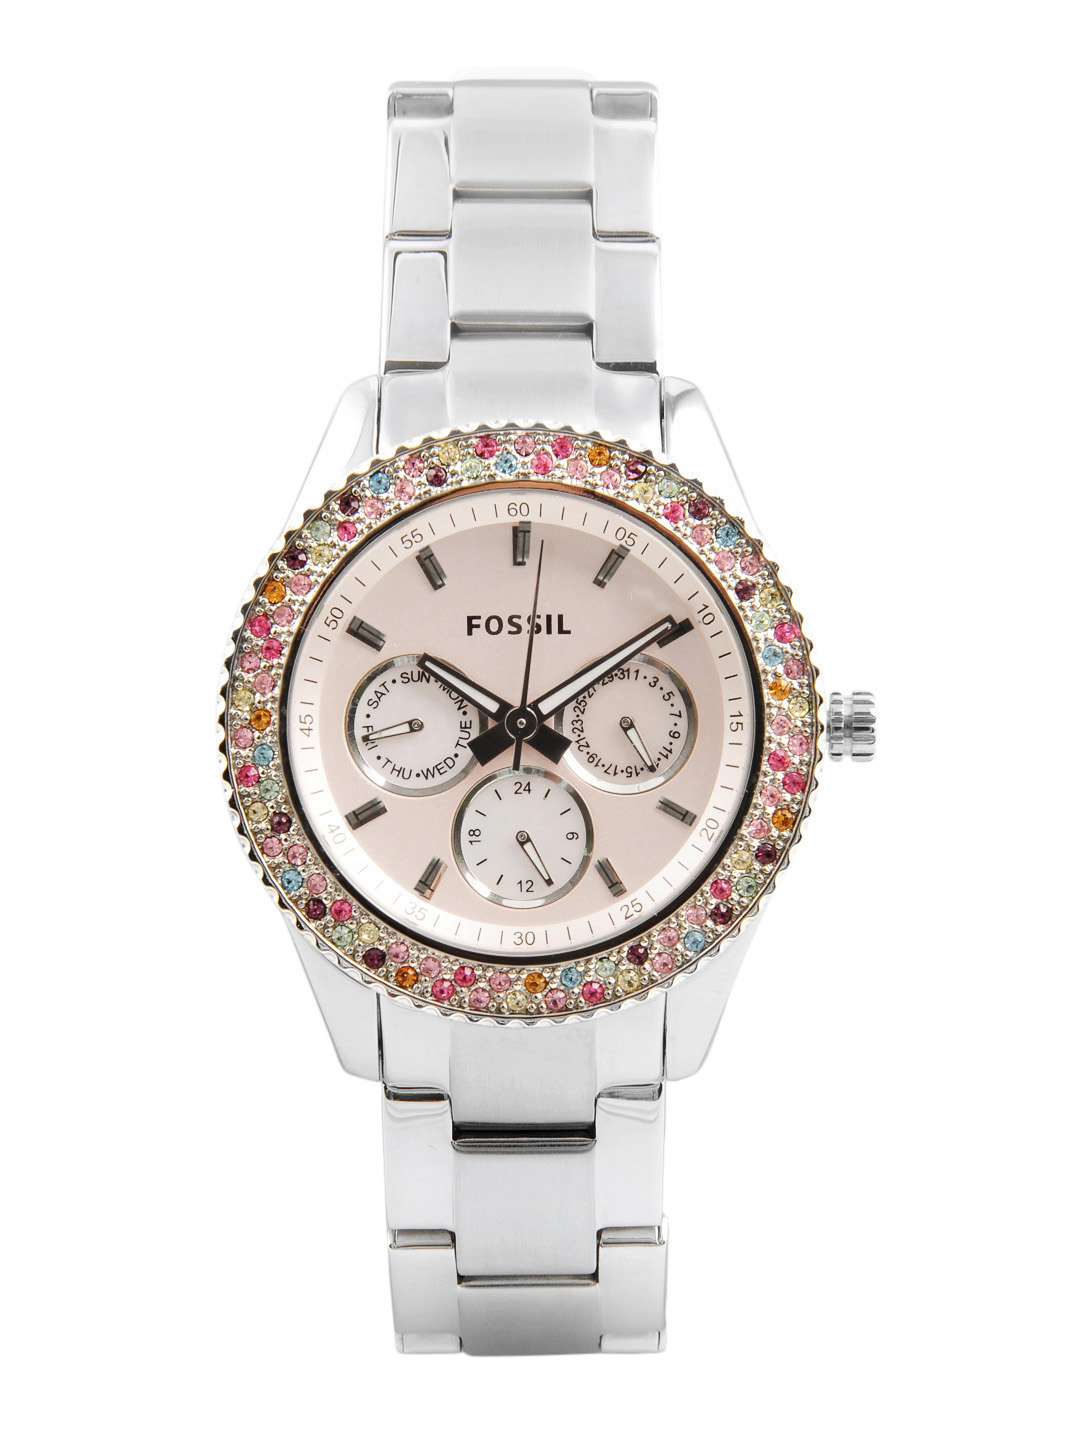

In [24]:
watches

In [25]:
resized_path = 'fashion-dataset/images/resized_watches_images'
os.makedirs(resized_path, exist_ok=True)

In [26]:
filepath = "C:/Users/atuam/Pictures/pictures_of_watches/"

files = [f for f in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, f))]
for file in files:
    image = Image.open(filepath + file)
    new_sized_image = image.resize((128, 128))
    new_sized_image.save(resized_path +'/'+ file)

==============Images==============


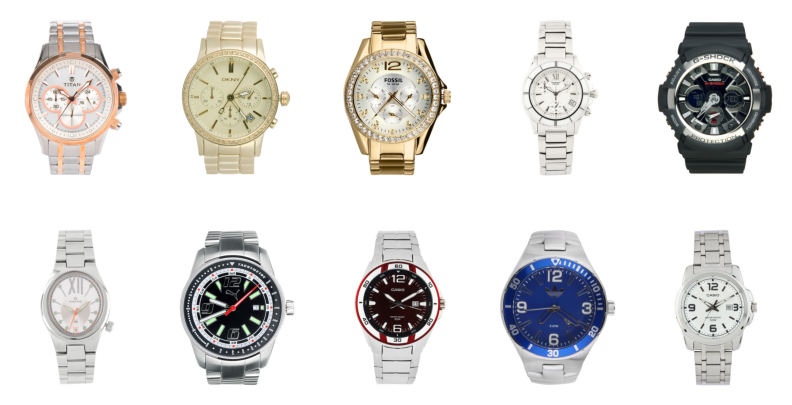

In [27]:
# Visualize the images in the new watch folder
def load_images():
    # Store the directory path in a variable
    images_path = "C:/Users/atuam/Pictures/pictures_of_watches"

    # List the images in this directory
    images = os.listdir(images_path)

    # Create an empty list to store images
    images_list = []

    # Load 10 Random Images: Sample out 10 images randomly from the above list
    sample_images = sample(images, 10)

    fig = plt.figure(figsize=(10, 5))

    print("==============Images==============")
    for i, img_name in enumerate(sample_images):
        plt.subplot(2, 5, i+1)
        img_path = os.path.join(images_path, img_name)
        loaded_img = Image.open(img_path)
        
        # Convert the PIL Image to a NumPy array
        img_array = tf.keras.preprocessing.image.img_to_array(loaded_img).astype('uint8')
        
        images_list.append(img_array)

        plt.imshow(loaded_img)
        plt.axis('off')

    plt.show()

    # Return the list of images
    return images_list

# Call the function to load and visualize images
loaded_images = load_images()

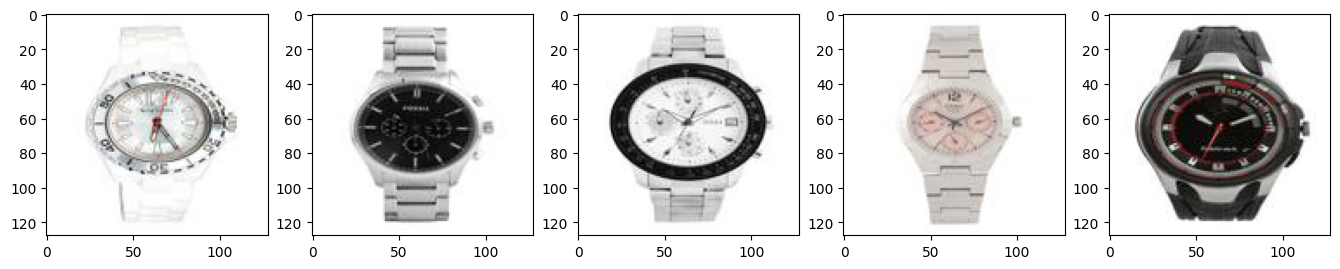

In [28]:
# Visualize the resized images 
filepath = "fashion-dataset/images/resized_watches_images"
valid_extensions = ['.jpg']
image_files = [file for file in os.listdir(filepath) if file.lower().endswith(tuple(valid_extensions))]
 
plt.figure(figsize=(20, 20))
for i in range(5):
    file = random.choice(image_files)
    image_path = os.path.join(filepath, file)
    img = mpimg.imread(image_path)
    ax = plt.subplot(1, 6, i+1)
    plt.imshow(img)
plt.show()

In [29]:
watches_f = [file for file in os.listdir(filepath) if file.endswith('.jpg')]

dataset = []
 
for file in image_files[:]:  
    image_path = os.path.join(filepath, file)  # Fixed the path joining
    image = cv2.imread(image_path)
    if image is not None:
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        image = (image - 127.5) / 127.5
        dataset.append(image)


In [30]:
dataset

[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        ...,
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]], 

In [31]:
# Set the batch size
BATCH_SIZE = 128

# Create a TensorFlow dataset
image_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(len(dataset)).batch(BATCH_SIZE)

### Build the generator

In [32]:
def build_gen():
    model = Sequential()
    model.add(Dense(32 * 32 * 128, input_shape=(128,)))
    model.add(Reshape((32, 32, 128)))
    
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(UpSampling2D())
    model.add(Conv2D(32, kernel_size=3, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Conv2D(3, kernel_size=3, padding="same"))  
    model.add(Activation("tanh"))
    return model

In [33]:
generator = build_gen()

In [34]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 131072)            16908288  
                                                                 
 reshape (Reshape)           (None, 32, 32, 128)       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 64, 64, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        73792     
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64, 64, 64)        0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


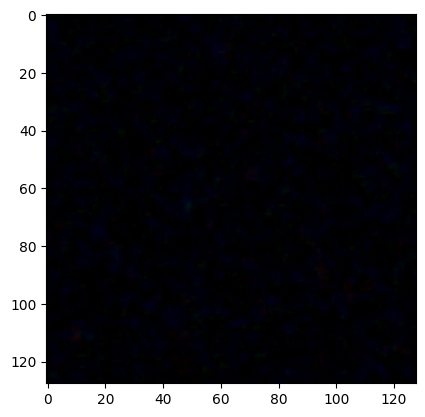

In [35]:
noise = tf.random.normal([1, 128])

# Generate the image using the generator
generated_image = generator(noise, training=False)

# Display the generated color image
plt.imshow(generated_image[0], cmap='gray')
plt.show()

1/1 [==============================] - 1s 664ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


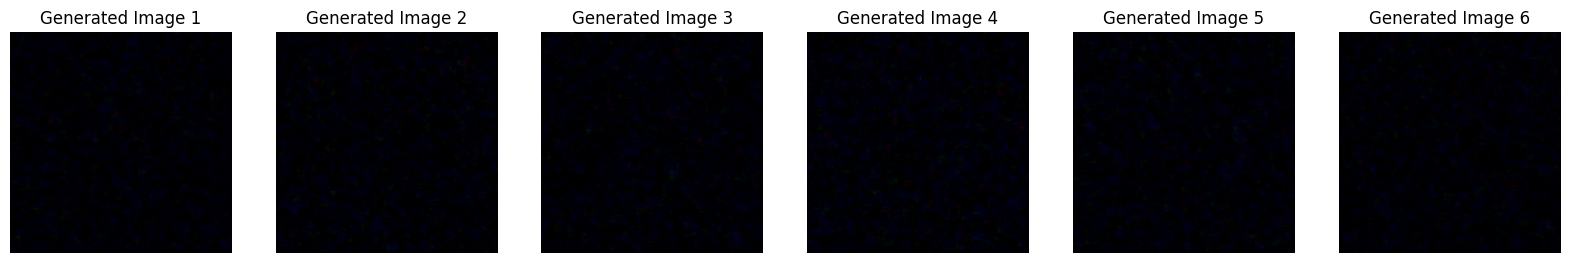

In [36]:
# Define the number of images you want to generate
num_images_to_generate = 6

# Generate random noise as input to the generator
random_noise = np.random.randn(num_images_to_generate,128, 1)

# Generate new fashion images using the generator
generated_images = generator.predict(random_noise)

# Setup the subplot formatting to display the generated images
fig, ax = plt.subplots(1, num_images_to_generate, figsize=(20, 20))

# Loop through the generated images and display them
for idx, img in enumerate(generated_images):
    ax[idx].imshow(np.squeeze(img), cmap='gray')  # Use 'cmap' parameter for grayscale images
    ax[idx].axis('off')
    ax[idx].set_title(f"Generated Image {idx + 1}")

plt.show()

In [37]:
generated_images.shape

(6, 128, 128, 3)

- The generated images above are the random noise from which the new fashion items will be generated

### Build the discriminator

In [38]:
# Build the reduced discriminator
def build_dis():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3), padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, 3, strides=2, padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, 3, strides=2, padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [39]:
discriminator = build_dis()

In [40]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 32)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)      

In [41]:
# Define the number of images you want to generate
num_images_to_generate2 = 6

# Generate random noise as input to the generator
random_noise2 = np.random.randn(num_images_to_generate2,128, 128, 3)

# Generate new fashion images using the generator
generated_images2 = discriminator.predict(random_noise2)


1/1 [==============================] - 0s 79ms/step


In [42]:
generated_images2.shape

(6, 1)

In [43]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 40ms/step


In [44]:
img.shape

(4, 128, 128, 3)

In [45]:
iv = discriminator.predict(img)

1/1 [==============================] - 0s 26ms/step


In [46]:
iv.shape

(4, 1)

## Construct Training Loop
- Define the Loss function and setup Optimizers

In [47]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [48]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Save checkpoints

In [49]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Defining the training loop

In [71]:
# EPOCHS = 3500
EPOCHS = 1
noise_dim = 128
num_examples_to_generate = 12

# The seed will be reused overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [72]:
# Funtion created to train the GAN
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [73]:
def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

# Folder path to save generated images
output_folder = 'gen_images'
create_folder(output_folder)

## Creating the function to generate and save images

In [74]:
# Function to generate and save images
def generate_and_save_images(model, epoch, test_input, output_folder):
    predictions = model(test_input, training=False)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        generated_image = predictions[i] * 127.5 + 127.5
        generated_image = np.clip(generated_image, 0, 255).astype(np.uint8)

        # Save each generated image individually
        image_filename = os.path.join(output_folder, f"Generated_image{epoch:04d}_{i}.png")
        plt.imsave(image_filename, generated_image)

        plt.imshow(generated_image)
        plt.axis('off')

    # Display the generated images in a 4x4 grid
    plt.tight_layout()
    plt.show()

## Creating the function to train the GAN

In [75]:
# Function to train the GAN
def train(dataset, epochs, output_folder):
    generator_losses_history = []
    discriminator_losses_history = []
    
    
    for epoch in range(epochs):
        start = time.time()
        generator_losses = []
        discriminator_losses = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            generator_losses.append(gen_loss)
            discriminator_losses.append(disc_loss)

        # Average losses over all batches
        avg_gen_loss = np.mean(generator_losses)
        avg_disc_loss = np.mean(discriminator_losses)
        
        # Store losses for plotting
        generator_losses_history.append(avg_gen_loss)
        discriminator_losses_history.append(avg_disc_loss)


        # Produce images for the GIF and save them
        generate_and_save_images(generator, epoch + 1, seed, output_folder)

        # Print losses
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
        print('Generator Loss: {:.4f}, Discriminator Loss: {:.4f}'.format(avg_gen_loss, avg_disc_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            generator.save_weights(os.path.join(output_folder, f"generator_weights_epoch_{epoch + 1}.h5"))
            discriminator.save_weights(os.path.join(output_folder, f"discriminator_weights_epoch_{epoch + 1}.h5"))
            
    # Plot the generator and discriminator losses
    plt.figure(figsize=(10, 5))
    plt.plot(generator_losses_history, label='Generator Loss')
    plt.plot(discriminator_losses_history, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(output_folder, 'loss_plot.png'))
    plt.show()


## Training the data and reviewing the performance of the generator and discrminator loss

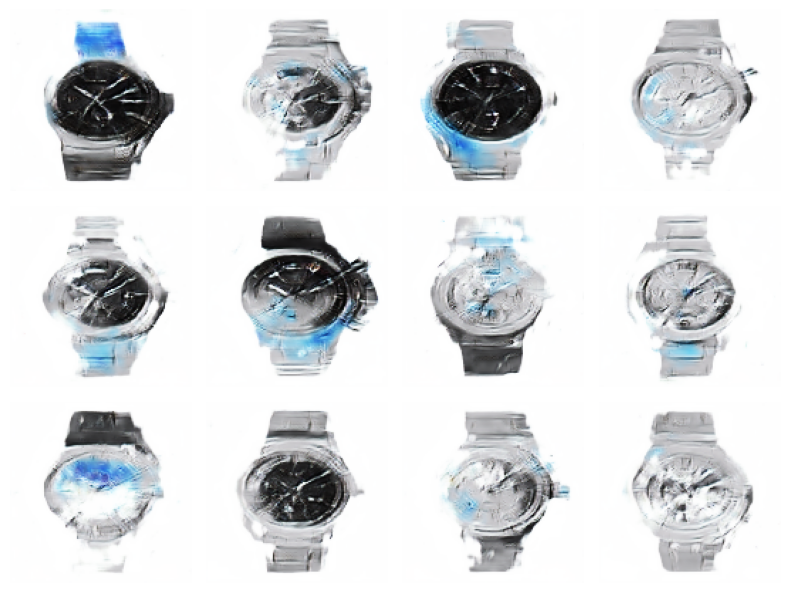

Time for epoch 1 is 123.55741047859192 sec
Generator Loss: 1.4552, Discriminator Loss: 0.9009


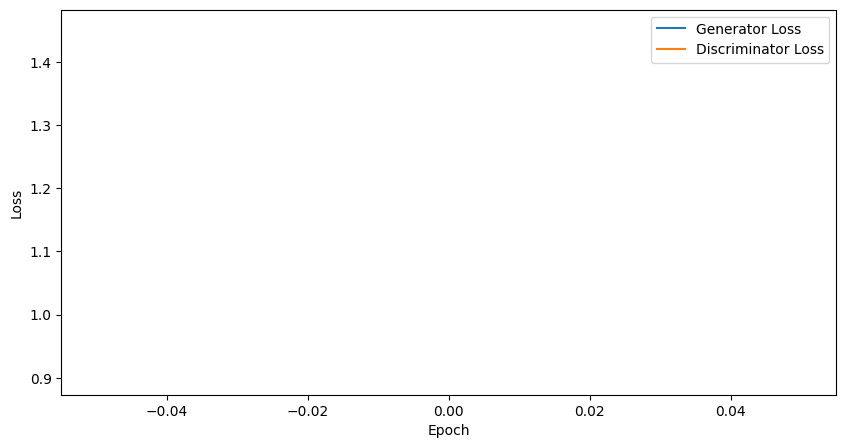

In [76]:
trained_data = train(image_dataset, EPOCHS, output_folder)

## Evaluate the data with Gini coefficient

In [56]:
def calculate_gini_coefficient(image):
    # Flatten the image into a 1D array
    image = image.flatten()

    # Sort the pixel values in ascending order
    image = np.sort(image)

    # Calculate the cumulative distribution function (CDF)
    index = np.arange(1,image.shape[0]+1)

#     # Normalize the CDF
#     normalized_cdf = cumulative_distribution / float(np.sum(sorted_pixels))

    # Calculate the Gini coefficient
    n = image.shape[0]
    return ((np.sum((2 * index - n  - 1) * image)) / (n * np.sum(image)))

- Gini coefficient for input images

In [57]:
# Convert the TensorFlow dataset to NumPy iterator
image_iterator = tf.data.Dataset.as_numpy_iterator(image_dataset).next()

# Initialize an empty list to store Gini coefficients for input images
input_gini_coefficients = []

# Iterate over each image in the dataset
for image in image_iterator:
    gini_coefficient = calculate_gini_coefficient(image)
    input_gini_coefficients.append(gini_coefficient)

# Print or use the calculated Gini coefficients for input images as needed
print("Gini Coefficients for Input Images:", input_gini_coefficients)

Gini Coefficients for Input Images: [0.7673228219668368, 0.2534691055169895, 0.3225267989651467, 0.5030117256527187, 0.8973089529813405, 0.10383180435132924, 0.20158311383672128, 0.14203857826463212, 0.32886856310765517, 0.14753906686096593, 0.971039800007218, 0.1476256158151495, 0.4455148029455218, 0.9980297277852044, 0.9575250114958788, 0.8219324962397594, 0.8557708553323157, 1.1595828099571712, 0.30837513764180463, 0.1325123241007289, 0.5866795290562334, 0.613711739983649, 0.4460445198018613, 0.6730771157650024, 0.3584418054276413, 0.17287716106589304, 1.0838770274099974, 1.005886178230731, 0.5564338482923408, 0.9208500937730636, 0.24161604159949127, 0.15019562692961366, 0.2593451778619207, 0.257728522619658, 0.1214877761319487, 0.06694844329801397, 0.9176456017910216, 0.8676939079913668, 0.2274643698279933, 0.31140691894885203, 0.23337648342759523, 0.21676354500717362, 0.23339903172227852, 0.4192362463045581, 0.2906962788204205, 0.18245315067654647, 0.153680314786713, 0.12840141599

### Gen

In [59]:
output_folder = 'gen_images'

In [61]:
import os
import cv2

output_gini = []

for filename in os.listdir(output_folder):
    image_path = os.path.join(output_folder, filename)
    image = cv2.imread(image_path)
    
    if image is not None:
        # Normalize the image
        image = (image - 127.5) / 127.5
        output_gini.append(image)

In [62]:
output_gini_coeff = []

for image in output_gini:
    output_gini_coeff.append(calculate_gini_coefficient(image))

In [63]:
output_gini_coeff

[-3.18967899881934,
 -3.864884696134593,
 -3.4130599436184887,
 -2.7898657751318416,
 -3.1473396306534798,
 -2.870963100282173,
 -2.942754662685546,
 -3.5884649747312114,
 -3.603539016129434,
 -3.3853396046689617,
 -2.7981423949442217,
 -3.1692646674714475,
 3.7795886646132555,
 3.484540820354319,
 3.6231063486449284,
 6.029554108238119,
 4.246956168713792,
 5.496420594291074,
 4.769515645348385,
 3.573517213366596,
 3.944192158590288,
 3.8674313471893367,
 6.146859180068651,
 3.4438216772789008,
 1.2874153209096946,
 1.2926746856055764,
 1.2854227570363461,
 1.5592719813589773,
 1.3833846510455887,
 1.5264377141893355,
 1.4217929964029734,
 1.3045843480575647,
 1.3542759344934194,
 1.3349913638392883,
 1.5784444378714628,
 1.2421393064390047,
 0.8679351082695664,
 0.8841622493798179,
 0.8801763177542352,
 1.0031773343925132,
 0.9364945746311926,
 1.0131064139587105,
 0.9287256140837394,
 0.8939868131071457,
 0.8990779215624547,
 0.8933550754988421,
 1.0154647590333,
 0.879168353398439

In [64]:
len(output_gini_coeff)

42001

### The mean and standard deviation of the input images

In [65]:
mean_input = np.mean(input_gini_coefficients)
mean_input

0.5180429249954974

In [66]:
std_input = np.std(input_gini_coefficients)
std_input

0.46101164053218385

### The mean and standard deviation of the Generated/output images

In [67]:
mean_gen = np.mean(output_gini_coeff)
mean_gen

0.37907003314159476

In [68]:
std_gen = np.std(output_gini_coeff)
std_gen

0.23893545186234932

## Calculating the Z-test

In [69]:
# Z-score calculation
z_score = (mean_input - mean_gen) / np.sqrt((std_input**2 + std_gen**2)) 

# Two-tailed p-value
p_value = 2 * (1 - norm.cdf(np.abs(z_score)))

# Print results
print("Z-score:", z_score)
print("P-value:", p_value)

# Check if the result is statistically significant
alpha = 0.05
if p_value < alpha:
    print("The difference is statistically significant (reject the null hypothesis)")
else:
    print("The difference is not statistically significant (fail to reject the null hypothesis)")

Z-score: 0.26764092743774937
P-value: 0.7889757243005375
The difference is not statistically significant (fail to reject the null hypothesis)


## Visualizing the Gini coefficient

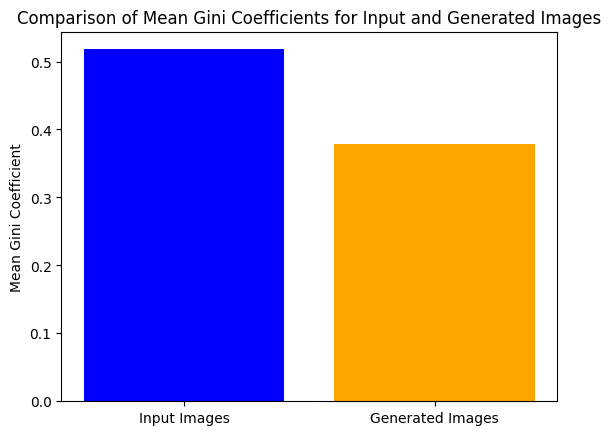

In [70]:
# Plotting
labels = ['Input Images', 'Generated Images']
values = [mean_input, mean_gen]

plt.bar(labels, values, color=['blue', 'orange'])
plt.ylabel('Mean Gini Coefficient')
plt.title('Comparison of Mean Gini Coefficients for Input and Generated Images')
plt.show()